In [370]:
#from speedml import Speedml
import csv
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
import math
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
import pg8000
import sys
import os
import pathlib2
import warnings
warnings.filterwarnings('ignore')

Upload data from home dir

In [393]:
mdata = pd.read_csv("../data/mouse_smart_data.csv")

Pull Recording date and set as index and change to datetime format 

In [339]:
def trip_mod(x):
    trimod = x[(x["anno.res_index_label"] >= 0.75) &(x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "63x go")]
    return trimod

def dub_mod(x):
    dubmod = x[(x["anno.res_index_label"] >= 0.75) & (x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "63x no go")]
    return dubmod

def morph_pend(x):
    morphpend = x[(x["anno.res_index_label"] >= 0.75) & (x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "No look")]
    return morphpend

def single_mod(x):
    singlemod = x[(x["anno.res_index_label"] < 0.75)]
    return singlemod

def trans_pend(x):
    transpend = x[(x["anno.res_index_label"] == 1.1)]
    return transpend

In [340]:
def reclassify(df):
    tri = trip_mod(df)
    tri['modality class'] = 'Triple Modality'
    dub = dub_mod(df)
    dub['modality class'] = 'Double Modality'
    morph_p = morph_pend(df)
    morph_p['modality class'] = 'Pending Morph'
    single = single_mod(df)
    single['modality class'] = 'EPhys Only'
    trans_p = trans_pend(df)
    trans_p['modality class'] = 'Pending Trans'
    return tri, dub, morph_p, single, trans_p

In [341]:
def concat_df(a, b, c, d, e):
    frames = (a, b, c, d, e)
    df = pd.concat(frames)
    return df

In [342]:
def modality_reclass(df):
    return concat_df(*reclassify(df))

In [343]:
#several of the below cells can go into a function for formatting and pivotting the dataframe for plotting
mdata['recording_date'] = pd.to_datetime(mdata['recording_date'], format='%Y-%m-%d')
mdata['63x_call'].fillna("No look", inplace=True)
#need documentation as to why we are setting NaN res index values to 1.1
mdata['anno.res_index_label'].fillna(1.1, inplace=True)
mdata.head()

,recording_date,anno.res_index_label,patched_cell_container,name,63x_call
0,2018-01-02,1.000000,P8S4_180102_351_A01,Chat-IRES-Cre-neo;Ai14-365769.04.02.01,63x go
1,2018-01-02,0.000000,P8S4_180102_352_A01,Chat-IRES-Cre-neo;Ai14-365769.04.02.02,No look
2,2018-01-02,0.745543,P8S4_180102_353_A01,Chat-IRES-Cre-neo;Ai14-365769.05.02.01,No look
3,2018-01-02,0.880454,P9S4_180102_401_A01,Pdyn-T2A-CreERT2;Ai14-366659.04.01.01,63x go
4,2018-01-02,1.000000,P9S4_180102_402_A01,Chat-IRES-Cre-neo;Ai14-365769.03.01.01,63x no go


In [344]:
mdata1 = modality_reclass(mdata)

In [345]:
mdata1.tail()

,recording_date,anno.res_index_label,patched_cell_container,name,63x_call,modality class
1798,2018-05-23,1.1,P2S4_180523_051_A01,Htr3a-Cre_NO152;Ai14-390981.04.02.01,No look,Pending Trans
1799,2018-05-23,1.1,P2S4_180523_052_A01,Htr3a-Cre_NO152;Ai14-390981.04.02.02,No look,Pending Trans
1800,2018-05-23,1.1,PAS4_180523_452_A01,Htr3a-Cre_NO152;Ai14-390981.05.01.02,No look,Pending Trans
1801,2018-05-23,1.1,PBS4_180523_508_A01,Slc17a8-IRES2-Cre;Ai14-390760.02.02.01,No look,Pending Trans
1802,2018-05-23,1.1,PBS4_180523_509_A01,Slc17a8-IRES2-Cre;Ai14-390760.02.02.02,No look,Pending Trans


Group Recording date with all other variables

In [346]:
mdata1 = mdata1[['recording_date', 'modality class', 'name']]
mdata1 = mdata1.groupby(['recording_date', 'modality class']).agg(['count'])
#mdata1 = mdata1.groupby(['recording_date']).count()

#mdata1

In [347]:
mdata1 = mdata1.reset_index()
mdata1 = mdata1.set_index(['recording_date', 'modality class']).unstack(level=-1).fillna(0).cumsum()

In [348]:
mdata1

name                                         \
                         count                                          
modality class Double Modality EPhys Only Pending Morph Pending Trans   
recording_date                                                          
2018-01-02                 1.0        2.0           0.0           0.0   
2018-01-03                 3.0        3.0           0.0           0.0   
2018-01-04                 3.0        4.0           0.0           0.0   
2018-01-05                 3.0        5.0           0.0           0.0   
2018-01-08                 7.0       19.0           0.0           0.0   
2018-01-09                10.0       25.0           1.0           0.0   
2018-01-10                16.0       37.0           1.0           0.0   
2018-01-11                20.0       41.0           1.0           0.0   
2018-01-12                24.0       50.0           1.0           0.0   
2018-01-15                26.0       54.0           1.0           0.0   
2018-01-16                26.0       54.0           1.0           0.0   
2018-01-17                27.0       57.0           1.0           0.0   
2018-01-18                29.0       63.0           1.0           0.0   
2018-01-19                36.0       67.0           1.0           0.0   
2018-01-22                39.0       73.0           2.0           0.0   
2018-01-23                41.0       78.0           5.0           0.0   
2018-01-24                46.0       88.0           6.0           1.0   
2018-01-25                47.0       94.0           6.0           1.0   
2018-01-26                50.0       99.0           6.0           1.0   
2018-01-29                52.0      103.0           6.0           1.0   
2018-01-30                56.0      108.0           8.0           1.0   
2018-01-31                59.0      114.0          12.0           1.0   
2018-02-01                61.0      118.0          12.0           1.0   
2018-02-02                66.0      123.0          13.0           1.0   
2018-02-05                68.0      138.0          13.0           1.0   
2018-02-06                70.0      151.0          14.0           1.0   
2018-02-07                73.0      165.0          18.0           1.0   
2018-02-09                73.0      165.0          18.0          14.0   
2018-02-12                74.0      168.0          18.0          33.0   
2018-02-13                74.0      171.0          18.0          52.0   
...                        ...        ...           ...           ...   
2018-04-13               215.0      446.0         121.0         133.0   
2018-04-16               215.0      463.0         127.0         133.0   
2018-04-17               215.0      469.0         146.0         133.0   
2018-04-18               215.0      477.0         153.0         133.0   
2018-04-19               215.0      478.0         154.0         133.0   
2018-04-23               215.0      485.0         171.0         133.0   
2018-04-24               215.0      485.0         177.0         148.0   
2018-04-25               215.0      485.0         177.0         163.0   
2018-04-27               215.0      485.0         177.0         183.0   
2018-04-30               215.0      485.0         177.0         201.0   
2018-05-01               215.0      485.0         177.0         233.0   
2018-05-02               215.0      485.0         177.0         265.0   
2018-05-04               215.0      485.0         177.0         292.0   
2018-05-07               215.0      485.0         177.0         315.0   
2018-05-08               215.0      485.0         177.0         338.0   
2018-05-09               215.0      485.0         177.0         355.0   
2018-05-11               215.0      485.0         177.0         363.0   
2018-05-14               215.0      485.0         177.0         402.0   
2018-05-15               215.0      485.0         177.0         416.0   
2018-05-16               215.0      485.0         177.0         434.0   
2018-05-18 

In [349]:
dates = sorted(tuple(mdata.recording_date.unique()))

In [350]:
#make this into a function that returns list of these 5 tuples
triple_mod = tuple(mdata1['name', 'count', 'Triple Modality'])
double_mod = tuple(mdata1['name', 'count', 'Double Modality'])
ephys_only = tuple(mdata1['name', 'count', 'EPhys Only'])
pending_morph = tuple(mdata1['name', 'count', 'Pending Morph'])
pending_trans = tuple(mdata1['name', 'count', 'Pending Trans'])

In [ ]:
def get_current_date():
    current_date = pd.to_datetime(dates[-1])
    return current_date
get_current_date()

In [ ]:
def get_current_total():
    total = triple_mod[-1] + double_mod[-1] + ephys_only[-1] + pending_morph[-1] + pending_trans[-1]
    return total
current_progress = get_current_total()
current_progress

In [ ]:
def get_current_goal():
    d0 = pd.to_datetime(dates[0])
    d1 = get_current_date()
    total2_today = (d1 - d0).days
    total2_today
    current_goal = 3500/float(271)*total2_today
    return current_goal
current_goal = get_current_goal()
current_goal

In [ ]:
diff = current_progress - current_goal
diff

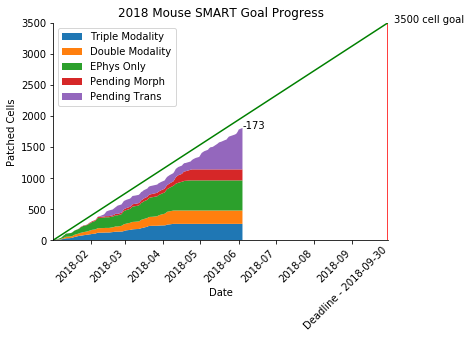

In [435]:
#h_line1 = 3500
#h_line2 = 700
x = dates
y = [triple_mod, double_mod, ephys_only, pending_morph, pending_trans]

labels = ["Triple Modality", "Double Modality", "EPhys Only", "Pending Morph", "Pending Trans"]
fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
progress = ax.stackplot(x, y, labels = labels)
ax.legend(loc=2)
goal_line = ax.plot([0,1], [0,1], color='g', transform=ax.transAxes)
#plt.gcf().autofmt_xdate()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(['2018-01-02', '2018-09-30'])
ax.set_ylim([0, 3500])
plt.vlines(x='2018-09-30', ymin=0, ymax=3500, color='r')
#plt.axvline('2018-09-30', color = 'r')
#plt.hlines(y=h_line1, xmin=min(x), xmax='2018-09-30', color='g')
#plt.hlines(y=h_line2, xmin=min(x), xmax='2018-09-30', color='g')
#plt.axhline('3500', color='g')
#plt.axhline('700', color='g')
plt.title("2018 Mouse SMART Goal Progress")
plt.ylabel('Patched Cells')
plt.xlabel('Date')
plt.text('2018-10-05', '3500', "{}".format("3500 cell goal"))
plt.text(get_current_date(), get_current_total(), "{}".format(int(diff)))
#plt.text('2018-10-05', '700', "{}".format("20% triple modality goal"))
plt.text('2018-09-30', '-200', "{}".format("Deadline - 2018-09-30"), rotation=45, ha='right')
plt.savefig('../figures/ouse_SMART_Goal_2018_Progress', dpi=300)

In [360]:
num_days = len(x)
num_days

93

In [ ]:
def get_current_goal():
    pass

In [ ]:
def add_goal_progress_2plot():
    pass

In [ ]:
#Insert a main at the bootom that executes all of the functions

Change patched cell container to total pcc

In [16]:
mdata['total_pcc'] = mdata['patched_cell_container'].cumsum()

In [17]:
md = mdata.reset_index()

In [18]:
mdata_time = md[['recording_date', 'total_pcc']]
mdata_time.set_index(['recording_date'], inplace=True)

Set goal to 400 tubes

In [9]:
#mdata_time['goal'] = 3500

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
mdata_time.head()

,total_pcc
recording_date,
2018-01-02,6
2018-01-03,10
2018-01-04,11
2018-01-05,12
2018-01-08,34


Make line plot

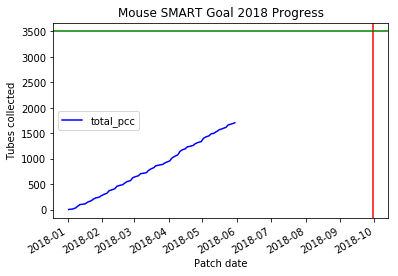

In [20]:
mdata_time.plot(color = ['b', 'g'])
plt.axvline('2018-09-30', color = 'r')
plt.axhline('3500', color='g')
plt.xlabel('Patch date')
plt.ylabel('Tubes collected')
plt.title('Mouse SMART Goal 2018 Progress')
full_fig_path = str(home/"documents"/"github"/"SMART_goals"/"figures"/"mouse_total_pcc.png")
#plt.savefig(full_fig_path, dpi=300)